In [1]:
import sys
!{sys.executable} -m pip install pascal_voc_writer

In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go
from PIL import Image, ImageDraw
import glob
import json

In [3]:
HOME = os.getcwd()
HOME

'/kaggle/working'

### Split data

In [4]:
dataset_path = "/kaggle/input/arthropod-taxonomy-orders-object-detection-dataset/ArTaxOr"
annotation_list = glob.glob(f"{dataset_path}/*/annotations/*.json")

In [5]:
data = pd.DataFrame()
data["annotation_dir"] = annotation_list

In [6]:
def read_json_data(jsonfile):
    # Initialize a dictionary to store the parsed data, with keys for different attributes
    rows = {"id": [], "img_dir":[] ,"img_w":[] , "img_h" : [], "x": [], "y": [], "w": [], "h": [],
            "sp_type": [] ,"xc":[] , "yc":[], "bb_height" : [] , "bb_width": [] , "bb_left":[] , "bb_top":[]}
    
    # Open and read the JSON file
    json_f = open(jsonfile)
    json_f = json.load(json_f)
    
    # Iterate over all regions in the JSON file
    for region in json_f["regions"]:
        
        # Extract the unique ID of the asset
        id = json_f["asset"]["id"]
        
        # Extract the image directory path, removing the first 16 characters
        img_dir = json_f["asset"]["path"][16:]
        
        # Extract the type of the region (semantic tag)
        sp_type = region["tags"][0]
        
        # Extract the image dimensions (width and height)
        img_w = json_f["asset"]["size"]["width"]
        img_h = json_f["asset"]["size"]["height"]
        
        # Extract the bounding box parameters: left (x), top (y), width, and height
        x = region["boundingBox"]["left"]
        y = region["boundingBox"]["top"]
        w = region["boundingBox"]["width"]
        h = region["boundingBox"]["height"]
        
        # Normalize the bounding box dimensions with respect to image dimensions
        bb_height = region["boundingBox"]["height"] / img_h
        bb_width = region["boundingBox"]["width"] / img_w
        
        # Normalize the bounding box position with respect to image dimensions
        bb_left = region["boundingBox"]["left"] / img_w
        bb_top = region["boundingBox"]["top"] / img_h
        
        # Calculate the center coordinates of the bounding box (normalized)
        xcenter = region['boundingBox']['left']/img_w + 0.5 * bb_width
        ycenetr = region['boundingBox']['top']/img_h + 0.5 * bb_height
        
        # Append all extracted and calculated data to the respective lists in the dictionary
        rows["id"].append(id)
        rows["img_dir"].append(img_dir)
        rows["sp_type"].append(sp_type)
        rows["img_w"].append(img_w)
        rows["img_h"].append(img_h)
        
        rows["x"].append(x) # xmin
        rows["y"].append(y) # ymin
        rows["w"].append(w) # width of bounding box
        rows["h"].append(h) # height of bounding box
        
        rows["bb_height"].append(bb_height) # normalized height of bounding box
        rows["bb_width"].append(bb_width)   # normalized width of bounding box
        rows["bb_left"].append(bb_left)     # normalized left position
        rows["bb_top"].append(bb_top)       # normalized top position
        rows["xc"].append(xcenter)          # normalized x-center
        rows["yc"].append(ycenetr)          # normalized y-center

    # Return the dictionary containing all extracted and calculated data
    return rows


In [7]:
from tqdm.notebook import tqdm
#coulmns = ["img_dir" , "sp_type" , "hight" , "width" , "left" ,"top"]
data_list = []

for json_file in tqdm(data["annotation_dir"]):
    rows = read_json_data(json_file)
    data_list.append(pd.DataFrame.from_dict(rows))  # Convert rows to DataFrame and add to list

# Concatenate all data frames in the list into a single DataFrame
df = pd.concat(data_list, ignore_index=True)

  0%|          | 0/15376 [00:00<?, ?it/s]

In [8]:
df['sp_type'].value_counts()

sp_type
Hymenoptera    3216
Hemiptera      2994
Lepidoptera    2899
Coleoptera     2793
Diptera        2673
Araneae        2527
Odonata        2503
Name: count, dtype: int64

In [9]:
from sklearn.model_selection import train_test_split

# Initial split: 80% for training, 20% for temp
train, temp = train_test_split(df, test_size=0.2, random_state=42)

# Split the temp set: 1/2 of temp for test, 1/2 of temp for validation (1:1 ratio in temp)
test, valid = train_test_split(temp, test_size=0.5, random_state=42)

# This results in:
# - 80% of the data in train
# - 10% of the data in test
# - 10% of the data in validation

train.to_csv(f'{HOME}/train_medata.csv', index=False)
test.to_csv(f'{HOME}/test_medata.csv', index=False)
valid.to_csv(f'{HOME}/valid_medata.csv', index=False)

### Convert to VOC

In [10]:
import glob
import json
import pandas as pd

# Find all .vott files in the specified directory
pfiles = glob.glob(f'{dataset_path}/**/*.vott', recursive=True)

# List to hold individual DataFrames
dataframes = []

# Iterate through each found file
for f in pfiles:
    with open(f) as file:
        pdata = json.load(file)
        # Append the DataFrame for the current file to the list
        dataframes.append(pd.DataFrame(list(pdata['assets'].values())))


# Concatenate all DataFrames in the list into a single DataFrame
df = pd.concat(dataframes, ignore_index=True)

# Clean the 'path' column
df['path'] = df['path'].str.replace('file:F:/ArTaxOr/', '')

# Display the first few rows
df.head()

,format,id,name,path,size,state,type
0,jpg,2550e885b02db84a8f31e36faf4f72c1,002da3868a1a.jpg,Coleoptera/002da3868a1a.jpg,"{'width': 907, 'height': 1208}",2,1
1,jpg,3641c4e79eafbba7613f27490d871cb6,004de63c1ac1.jpg,Coleoptera/004de63c1ac1.jpg,"{'width': 3968, 'height': 2648}",2,1
2,jpg,b13010787800b033da886c1624f86ffc,00930401f173.jpg,Coleoptera/00930401f173.jpg,"{'width': 2048, 'height': 1536}",2,1
3,jpg,3f0d901456dc366d15ae553ece84e5a8,00eebccd5430.jpg,Coleoptera/00eebccd5430.jpg,"{'width': 2048, 'height': 1536}",2,1
4,jpg,1fe209a391e180c0114793fbf00b2690,01424bd88646.jpg,Coleoptera/01424bd88646.jpg,"{'width': 864, 'height': 565}",2,1


In [11]:
tags=pd.DataFrame(list(pdata['tags']))
pattern=r'[A-Z]'
labels=tags[tags.name.str.match(pattern)]
labels

,name,color
0,Lepidoptera,#5db300
1,Coleoptera,#e81123
2,Hymenoptera,#6917aa
3,Diptera,#015cda
4,Araneae,#4894fe
5,Hemiptera,#257ffe
6,Odonata,#257ffe


In [12]:
import os

# Loop through the DataFrame `df`
def create_annotation_dataframe(df: pd.DataFrame):
    annotations = []
    for i in range(len(df)):
        p = df['path'][i].split('/')
        p = p[0]
        afile = f'{dataset_path}/' + p + '/annotations/' + df['id'][i] + '-asset.json'
        
        if os.path.isfile(afile):
            with open(afile) as file:
                adata = json.load(file)
            
            xres, yres = adata['asset']['size']['width'], adata['asset']['size']['height'] 
            
            for j in range(len(adata['regions'])):
                h = adata['regions'][j]['boundingBox']['height'] / yres
                w = adata['regions'][j]['boundingBox']['width'] / xres
                tags = adata['regions'][j]['tags']
                
                # Create a dictionary for the current annotation
                annotation = {
                    'label': tags[0],
                    'label_idx': labels[labels['name'] == tags[0]].index[0],
                    'xres': xres,
                    'yres': yres,
                    'height': h,
                    'width': w,                              
                    'left': adata['regions'][j]['boundingBox']['left'] / xres,
                    'top': adata['regions'][j]['boundingBox']['top'] / yres,
                    'right': adata['regions'][j]['boundingBox']['left'] / xres + w,
                    'bottom': adata['regions'][j]['boundingBox']['top'] / yres + h, 
                    'area': h * w,
                    'xcenter': adata['regions'][j]['boundingBox']['left'] / xres + 0.5 * w,
                    'ycenter': adata['regions'][j]['boundingBox']['top'] / yres + 0.5 * h,
                    'blurred': int(any(ele == '_blurred' for ele in tags)),
                    'occluded': int(any(ele == '_occluded' for ele in tags)),
                    'truncated': int(any(ele == '_truncated' for ele in tags)),
                    'file': adata['asset']['path'].replace('file:F:/ArTaxOr/', ''),
                    'id': adata['asset']['id'],
                }
                
                # Append the annotation to the list
                annotations.append(annotation)
    return pd.DataFrame(annotations)

In [13]:
anno = create_annotation_dataframe(df)

In [14]:
train = pd.read_csv(f'{HOME}/train_medata.csv')
test = pd.read_csv(f'{HOME}/test_medata.csv')
valid = pd.read_csv(f'{HOME}/valid_medata.csv')

In [15]:
from pascal_voc_writer import Writer

!mkdir {HOME}/train
!mkdir {HOME}/valid
!mkdir {HOME}/test

In [16]:
train.head()

,id,img_dir,img_w,img_h,x,y,w,h,sp_type,xc,yc,bb_height,bb_width,bb_left,bb_top
0,ba8a256dc91b15f0841461bbaa3ef5e1,Hemiptera/05d1f00d3ce7.jpg,2048,1463,1272.584828,316.213999,471.746207,206.175676,Hemiptera,0.736552,0.286604,0.140927,0.230345,0.621379,0.216141
1,517be9939146b6a007ab303de12e7ff3,Odonata/f109659c6b22.jpg,2048,1365,687.185877,408.224299,842.168224,499.649533,Odonata,0.541147,0.482087,0.366044,0.411215,0.335540,0.299065
2,e91382c7f1ec2ee1cd24462ebf841d6f,Hymenoptera/0a35d5d86ae0.jpg,1536,2048,847.448276,617.931034,394.298851,362.911877,Hymenoptera,0.680077,0.390326,0.177203,0.256705,0.551724,0.301724
3,ef08b3a7a7c1f0a68ebd9886aae42bdf,Lepidoptera/9e919dfa0151.jpg,2063,1489,277.826429,238.182950,1469.495159,975.551724,Lepidoptera,0.490826,0.487548,0.655172,0.712310,0.134671,0.159962
4,a0047b250e4326fe43d17ccdc5eb144a,Hemiptera/1896c6262cdb.jpg,2048,1333,583.326897,59.152758,853.097931,1114.128178,Hemiptera,0.493103,0.462278,0.835805,0.416552,0.284828,0.044376


In [17]:
anno.head()

,label,label_idx,xres,yres,height,width,left,top,right,bottom,area,xcenter,ycenter,blurred,occluded,truncated,file,id
0,Coleoptera,1,907,1208,0.654215,0.320153,0.358976,0.139847,0.679129,0.794061,0.209449,0.519053,0.466954,0,0,0,Coleoptera/002da3868a1a.jpg,2550e885b02db84a8f31e36faf4f72c1
1,Coleoptera,1,3968,2648,0.739508,0.560992,0.027567,0.260492,0.588560,1.000000,0.414858,0.308063,0.630246,0,0,0,Coleoptera/004de63c1ac1.jpg,3641c4e79eafbba7613f27490d871cb6
2,Coleoptera,1,2048,1536,0.761494,0.752874,0.225216,0.040230,0.978089,0.801724,0.573309,0.601652,0.420977,0,0,0,Coleoptera/00930401f173.jpg,b13010787800b033da886c1624f86ffc
3,Coleoptera,1,2048,1536,0.651341,0.645833,0.248204,0.074713,0.894037,0.726054,0.420658,0.571121,0.400383,0,0,0,Coleoptera/00eebccd5430.jpg,3f0d901456dc366d15ae553ece84e5a8
4,Coleoptera,1,864,565,0.332982,0.141282,0.485872,0.372432,0.627154,0.705414,0.047044,0.556513,0.538923,0,0,0,Coleoptera/01424bd88646.jpg,1fe209a391e180c0114793fbf00b2690


In [18]:
import sys
from pascal_voc_writer import Writer
import shutil


def convert_pascalVOC_XML(df, type):

    for i in range(len(df)): # use above line for full dataset
        
        ldf=anno[anno.file == df.img_dir[i]].reset_index()

        img_path = os.path.join(dataset_path, ldf['file'].values[0])
        shutil.copy(img_path, f'{HOME}/{type}/')
        
        p = df.img_dir[i].split('/') 
    
        width, height = ldf.xres[0], ldf.yres[0]
        writer = Writer(df.img_dir[i], width, height)
        for j in range(len(ldf)):
            writer.addObject(ldf.label[j], 
                                int(ldf.left[j]*width), 
                                int(ldf.top[j]*height), 
                                int(ldf.right[j]*width),
                                int(ldf.bottom[j]*height))
        writer.save(f'{HOME}/{type}/'+p[1].replace('.jpg','.xml'))

In [19]:
convert_pascalVOC_XML(train, 'train')
convert_pascalVOC_XML(test, 'test')
convert_pascalVOC_XML(valid, 'valid')

In [20]:
import os
import xml.etree.ElementTree as ET
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_bounding_boxes(directory_folder, n_rows, n_cols):
    # Lấy danh sách các file XML trong thư mục
    xml_files = [f for f in os.listdir(directory_folder) if f.endswith('.xml')]
    xml_files = xml_files[:n_rows * n_cols]  # Lấy đủ số lượng ảnh cần hiển thị
    
    # Tạo figure để hiển thị các hình ảnh theo ma trận
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))
    axes = axes.flatten()  # Chuyển axes thành 1 chiều để dễ truy cập
    
    for i, xml_file in enumerate(xml_files):
        xml_path = os.path.join(directory_folder, xml_file)
        
        # Đọc thông tin bounding box từ file XML
        tree = ET.parse(xml_path)
        root = tree.getroot()
        
        # Tìm tên file ảnh từ file XML
        filename = root.find('filename').text
        image_path = os.path.join(directory_folder, filename)
        
        # Đọc ảnh bằng Pillow
        try:
            image = Image.open(image_path)
        except IOError:
            print(f"Không thể đọc ảnh: {image_path}")
            continue
        
        # Vẽ bounding box lên ảnh
        ax = axes[i]
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(filename)
        
        # Lấy các bounding box từ file XML
        for obj in root.findall('object'):
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            
            # Tạo một bounding box bằng matplotlib patches
            rect = patches.Rectangle(
                (xmin, ymin), xmax - xmin, ymax - ymin,
                linewidth=2, edgecolor='g', facecolor='none'
            )
            ax.add_patch(rect)
            
            # Thêm nhãn
            label = obj.find('name').text
            ax.text(xmin, ymin - 5, label, color='g', fontsize=10, backgroundcolor='black')
    
    # Xóa các ô trống nếu số lượng ảnh không chia hết cho n_rows * n_cols
    for j in range(i + 1, n_rows * n_cols):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

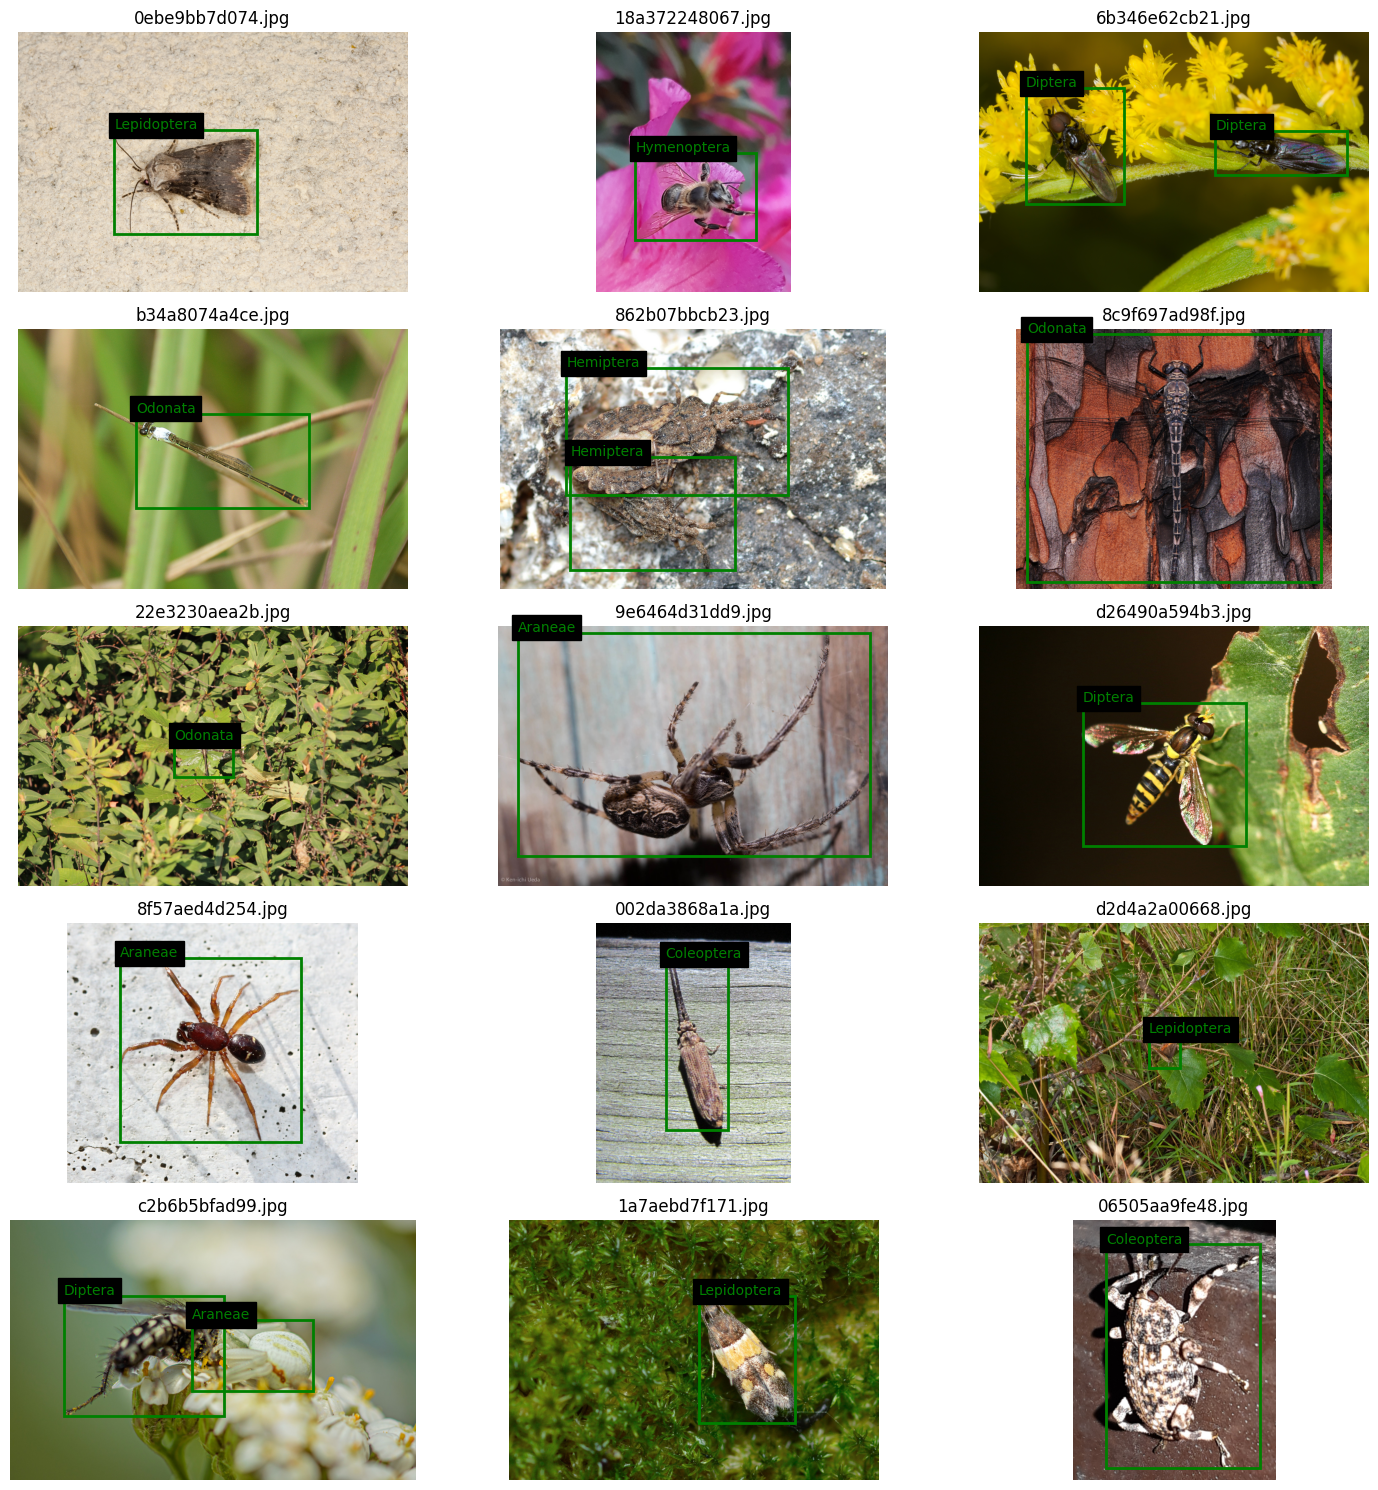

In [21]:
# Ví dụ cách sử dụng
draw_bounding_boxes(f'{HOME}/train', 5, 3)

### Faster RCNN

In [22]:
!git clone https://github.com/sovit-123/fastercnn-pytorch-training-pipeline.git

Cloning into 'fastercnn-pytorch-training-pipeline'...
remote: Enumerating objects: 1418, done.
remote: Counting objects: 100% (434/434), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 1418 (delta 353), reused 309 (delta 309), pack-reused 984 (from 2)
Receiving objects: 100% (1418/1418), 12.85 MiB | 18.07 MiB/s, done.
Resolving deltas: 100% (956/956), done.


In [23]:
%cd fastercnn-pytorch-training-pipeline/

/kaggle/working/fastercnn-pytorch-training-pipeline


In [24]:
!pip install -r requirements.txt

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 952.4/952.4 kB 20.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 77.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 6.5 MB/s eta 0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 4.6 MB/s eta 0:00:00
  Created wheel for vision_transformers: filename=vision_transformers-0.1.1.0-py3-none-any.whl size=48412 sha256=99d61fb1cd2dc8acd04ca73e1086a9f3a9afd0598449e438ccb36f2f0ae1bd0b

In [25]:
%%writefile data_configs/custom_data.yaml
# Images and labels direcotry should be relative to train.py
TRAIN_DIR_IMAGES: '/kaggle/working/train'
TRAIN_DIR_LABELS: '/kaggle/working/train'
VALID_DIR_IMAGES: '/kaggle/working/test'
VALID_DIR_LABELS: '/kaggle/working/test'

# Class names.
CLASSES: [
    '__background__',
    'Araneae', 'Coleoptera', 'Diptera', 'Hemiptera', 'Hymenoptera', 'Lepidoptera', 'Odonata'
]

# Number of classes (object classes + 1 for background class in Faster RCNN).
NC: 8

# Whether to save the predictions of the validation set while training.
SAVE_VALID_PREDICTION_IMAGES: True

Writing data_configs/custom_data.yaml


In [26]:
!export CUDA_VISIBLE_DEVICES=0,1

In [27]:
import torch
for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).name)

Tesla T4
Tesla T4


In [28]:
!python -m torch.distributed.launch \
--nproc_per_node=2 \
--use_env train.py \
--data data_configs/custom_data.yaml \
--epochs 5 \
--model fasterrcnn_resnet50_fpn \
--name custom_training --batch 4 \
--disable-wandb \
--project-dir /kaggle/working/output \
--use-train-aug

/opt/conda/lib/python3.10/site-packages/torch/distributed/launch.py:208: FutureWarning: The module torch.distributed.launch is deprecated
and will be removed in future. Use torchrun.
Note that --use-env is set by default in torchrun.
If your script expects `--local-rank` argument to be set, please
change it to read from `os.environ['LOCAL_RANK']` instead. See 
https://pytorch.org/docs/stable/distributed.html#launch-utility for 
further instructions

  main()
W1223 12:21:55.678000 136964964349760 torch/distributed/run.py:779] 
W1223 12:21:55.678000 136964964349760 torch/distributed/run.py:779] *****************************************
W1223 12:21:55.678000 136964964349760 torch/distributed/run.py:779] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1223 12:21:55.678000 136964964349760 torch/distributed/run.py:779] ************

In [29]:
# !python -m torch.distributed.launch \
#     --nproc_per_node=2 \
#     --use_env train.py \
#     --data data_configs/custom_data.yaml \
#     --epochs 5 \
#     --model fasterrcnn_resnet50_fpn_v2 \
#     --name custom_training --batch 4 \
#     --disable-wandb \
#     --project-dir /kaggle/working/output_resume \
#     --use-train-aug \
#     --weights /kaggle/working/output \
#     --resume-training


In [32]:
import torch
import yaml
from datasets import create_valid_dataset, create_valid_loader
from models.create_fasterrcnn_model import create_model
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from tqdm import tqdm
import numpy as np
from pprint import pprint

def evaluate_model(
    data_config_path, 
    model_name, 
    weights_path=None, 
    image_size=640, 
    batch_size=8, 
    num_workers=4, 
    device=None, 
    verbose=False, 
    square_training=False
):
    """
    Evaluate a trained object detection model for mAP and class-wise AP/AR.

    Parameters:
    - data_config_path (str): Path to the dataset configuration YAML file.
    - model_name (str): Name of the model architecture (e.g., 'fasterrcnn_resnet50_fpn').
    - weights_path (str, optional): Path to the trained model weights.
    - image_size (int, optional): Size of the input images.
    - batch_size (int, optional): Batch size for validation loader.
    - num_workers (int, optional): Number of workers for data loading.
    - device (str/torch.device, optional): Device to use for evaluation (e.g., 'cuda' or 'cpu').
    - verbose (bool, optional): Whether to print class-wise metrics.
    - square_training (bool, optional): Whether to use square image resizing.

    Returns:
    - dict: Evaluation metrics including mAP and class-wise AP/AR.
    """
    # Default to GPU if available
    if device is None:
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    # Load dataset configurations
    with open(data_config_path) as file:
        data_configs = yaml.safe_load(file)
    
    VALID_DIR_IMAGES = data_configs.get('TEST_DIR_IMAGES', data_configs.get('VALID_DIR_IMAGES'))
    VALID_DIR_LABELS = data_configs.get('TEST_DIR_LABELS', data_configs.get('VALID_DIR_LABELS'))
    NUM_CLASSES = data_configs['NC']
    CLASSES = data_configs['CLASSES']

    # Create the model
    create_model_fn = create_model[model_name]
    if weights_path is None:
        model, coco_model = create_model_fn(num_classes=NUM_CLASSES, coco_model=True)
        valid_dataset = create_valid_dataset(
            VALID_DIR_IMAGES, 
            VALID_DIR_LABELS, 
            image_size, 
            data_configs['COCO_91_CLASSES'], 
            square_training=square_training
        )
    else:
        model = create_model_fn(num_classes=NUM_CLASSES, coco_model=False)
        checkpoint = torch.load(weights_path, map_location=device)
        
        # Handle DataParallel weights
        if 'module.' in list(checkpoint['model_state_dict'].keys())[0]:
            checkpoint['model_state_dict'] = {
                k.replace('module.', ''): v for k, v in checkpoint['model_state_dict'].items()
            }
        
        model.load_state_dict(checkpoint['model_state_dict'])
        valid_dataset = create_valid_dataset(
            VALID_DIR_IMAGES, 
            VALID_DIR_LABELS, 
            image_size, 
            CLASSES, 
            square_training=square_training
        )
    
    model.to(device).eval()
    valid_loader = create_valid_loader(valid_dataset, batch_size, num_workers)

    # Evaluation function
    @torch.inference_mode()
    def evaluate(model, data_loader, device):
        metric = MeanAveragePrecision(class_metrics=verbose)
        preds, targets = [], []
        
        for images, labels in tqdm(data_loader, desc="Evaluating"):
            images = [img.to(device) for img in images]
            outputs = model(images)
            
            for i in range(len(images)):
                preds.append({
                    'boxes': outputs[i]['boxes'].detach().cpu(),
                    'scores': outputs[i]['scores'].detach().cpu(),
                    'labels': outputs[i]['labels'].detach().cpu()
                })
                targets.append({
                    'boxes': labels[i]['boxes'].detach().cpu(),
                    'labels': labels[i]['labels'].detach().cpu()
                })

        metric.update(preds, targets)
        return metric.compute()

    # Run evaluation
    metrics = evaluate(model, valid_loader, device)

    # Print results
    pprint(metrics)
    if verbose:
        print('\nClass-wise AP/AR:')
        for idx, cls in enumerate(CLASSES[1:], start=1):
            print(f"Class {cls}: AP={metrics['map_per_class'][idx-1]:.4f}, AR={metrics['mar_100_per_class'][idx-1]:.4f}")

    
    
    return metrics

In [36]:
metrics = evaluate_model(
    data_config_path='data_configs/custom_data.yaml',
    model_name='fasterrcnn_resnet50_fpn',
    weights_path='/kaggle/working/output/best_model.pth',
    image_size=640,
    batch_size=4,
    num_workers=4,
    device='cuda',
    verbose=True
)

Checking Labels and images...


/tmp/ipykernel_30/562396980.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weights_path, map_location=device)


  0%|          | 0/1823 [00:00<?, ?it/s]

Removed 0 problematic images and annotations.


Evaluating: 100%|██████████| 456/456 [04:55<00:00,  1.54it/s]


{'classes': tensor([1, 2, 3, 4, 5, 6, 7], dtype=torch.int32),
 'map': tensor(0.3951),
 'map_50': tensor(0.6392),
 'map_75': tensor(0.4240),
 'map_large': tensor(0.5177),
 'map_medium': tensor(0.2150),
 'map_per_class': tensor([0.4353, 0.3869, 0.2919, 0.3608, 0.2710, 0.4603, 0.5594]),
 'map_small': tensor(0.1129),
 'mar_1': tensor(0.3646),
 'mar_10': tensor(0.5285),
 'mar_100': tensor(0.5682),
 'mar_100_per_class': tensor([0.5635, 0.5719, 0.4942, 0.5893, 0.5116, 0.5950, 0.6520]),
 'mar_large': tensor(0.6829),
 'mar_medium': tensor(0.4155),
 'mar_small': tensor(0.2909)}

Class-wise AP/AR:
Class Araneae: AP=0.4353, AR=0.5635
Class Coleoptera: AP=0.3869, AR=0.5719
Class Diptera: AP=0.2919, AR=0.4942
Class Hemiptera: AP=0.3608, AR=0.5893
Class Hymenoptera: AP=0.2710, AR=0.5116
Class Lepidoptera: AP=0.4603, AR=0.5950
Class Odonata: AP=0.5594, AR=0.6520


In [1]:
(0.4353 + 0.3869 + 0.2919 + 0.3608 + 0.2710 + 0.4603 + 0.5594)/7

0.3950857142857144